In [2]:
import numpy as np
np.random.seed(0)
from scipy.stats import beta as sp_beta

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

import sys
sys.path.insert(0, '../../..')
import assignment
import leximin_assignment
import matrix_gen
import kde_utils

from tqdm import tqdm

import warnings

In [3]:
N = 30
N_INTVS = 5
N_EXPERIMENTS = 500  # 10 and 500

CAPACITIES = np.ones((N_INTVS,)) * (N // N_INTVS)

# Uniform distribution

In [15]:
params = (0, 1)
uniform_distribution = np.random.uniform

matrix_generator = matrix_gen.MatrixGenerator(
    uniform_distribution,
    params,
    N, N_INTVS
)

uniform_pofs = []

for _ in tqdm(range(N_EXPERIMENTS)):
    cost_matrix = matrix_generator.get_new_matrix(sort_rows=True)
    
    # Efficient assignment
    eff_assigner = assignment.AssignmentHelperV2(
        cost_matrix, CAPACITIES
    )
    eff_assignments = eff_assigner.ip_solve()
    eff_cost = eff_assigner.get_cost(eff_assignments)
    
    # Leximin assignment
    lex_assigner = leximin_assignment.LeximinAssignmentHelperV3(
        cost_matrix, CAPACITIES
    )
    with warnings.catch_warnings():  # temporarily suspense warnings
        warnings.simplefilter('ignore')
        lex_assignments = lex_assigner.solve()
    lex_cost = lex_assigner.get_cost(lex_assignments)
    
    uniform_pofs.append(lex_cost / eff_cost)
    
uniform_pofs = np.array(uniform_pofs)

100%|██████████| 500/500 [04:11<00:00,  1.99it/s]


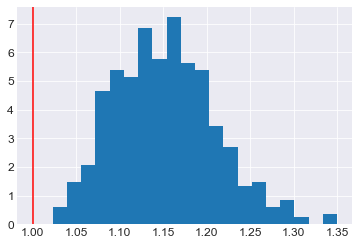

In [16]:
plt.hist(uniform_pofs, bins=20, density=True)
plt.axvline(1, c='r')
plt.show()

# Fitted beta distribution

In [9]:
params = (2.1076002312636923, 4.955761562695761)
beta_distribution = np.random.beta

matrix_generator = matrix_gen.MatrixGenerator(
    uniform_distribution,
    params,
    N, N_INTVS
)

beta_pofs = []

for _ in tqdm(range(N_EXPERIMENTS)):
    cost_matrix = matrix_generator.get_new_matrix(sort_rows=True)
    
    # Efficient assignment
    eff_assigner = assignment.AssignmentHelperV2(
        cost_matrix, CAPACITIES
    )
    eff_assignments = eff_assigner.ip_solve()
    eff_cost = eff_assigner.get_cost(eff_assignments)
    
    # Leximin assignment
    lex_assigner = leximin_assignment.LeximinAssignmentHelperV3(
        cost_matrix, CAPACITIES
    )
    with warnings.catch_warnings():  # temporarily suspense warnings
        warnings.simplefilter('ignore')
        lex_assignments = lex_assigner.solve()
    lex_cost = lex_assigner.get_cost(lex_assignments)
    
    beta_pofs.append(lex_cost / eff_cost)
    
beta_pofs = np.array(beta_pofs)

100%|██████████| 500/500 [03:54<00:00,  2.14it/s]


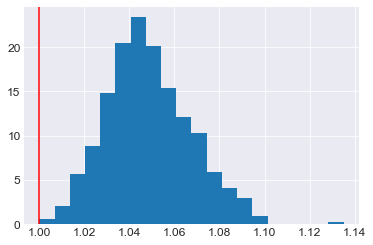

In [14]:
plt.hist(beta_pofs, bins=20, density=True)
plt.axvline(1, c='r')
plt.show()

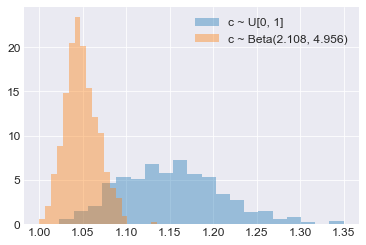

In [23]:
plt.hist(
    uniform_pofs, bins=20, alpha=0.4, density=True,
    label='c ~ U[0, 1]'
)
plt.hist(
    beta_pofs, bins=20, alpha=0.4, density=True,
    label='c ~ Beta(2.108, 4.956)'
)

plt.legend()
plt.show()

# Similarly sorted matrices

In [3]:
uniform_params = (0, 1)
uniform_distribution = np.random.uniform

beta_params = (2.1076002312636923, 4.955761562695761)
beta_distribution = np.random.beta

matrix_generator = matrix_gen.MatrixGenerator(
    uniform_distribution,
    uniform_params,
    N, N_INTVS
)

uniform_pofs = []
beta_pofs = []
pof_ratios = []

for _ in tqdm(range(N_EXPERIMENTS)):
    uniform_matrix, beta_matrix = matrix_generator.get_matrix_pair(
        beta_distribution, beta_params, sort_rows=True
    )
    
    for i, matrix in enumerate([uniform_matrix, beta_matrix]):
        # Efficient assignment
        eff_assigner = assignment.AssignmentHelperV2(
            matrix, CAPACITIES
        )
        eff_assignments = eff_assigner.ip_solve()
        eff_cost = eff_assigner.get_cost(eff_assignments)
        
        # Leximin assignment
        lex_assigner = leximin_assignment.LeximinAssignmentHelperV3(
            matrix, CAPACITIES
        )
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            lex_assignments = lex_assigner.solve()
        lex_cost = lex_assigner.get_cost(lex_assignments)
        
        if i == 0:
            uniform_pofs.append(lex_cost / eff_cost)
        else:
            beta_pofs.append(lex_cost / eff_cost)
    
    pof_ratios.append(uniform_pofs[-1] / beta_pofs[-1])
    
uniform_pofs = np.array(uniform_pofs)
beta_pofs = np.array(beta_pofs)
pof_ratios = np.array(pof_ratios)

100%|██████████| 500/500 [14:19<00:00,  1.72s/it]


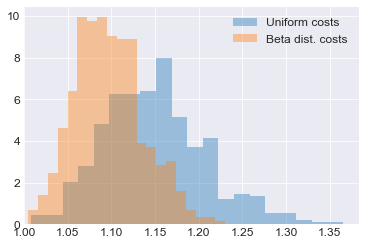

In [4]:
plt.hist(
    uniform_pofs, bins=20, alpha=0.4,
    density=True, label='Uniform costs'
)
plt.hist(
    beta_pofs, bins=20, alpha=0.4,
    density=True, label='Beta dist. costs'
)

plt.legend()
x0, x1 = plt.xlim()
plt.xlim(1, x1)
plt.show()

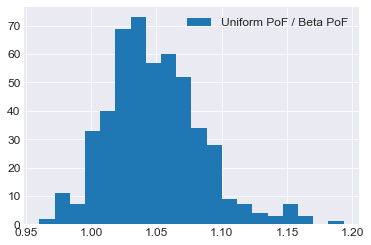

In [5]:
plt.hist(pof_ratios, bins=20, label='Uniform PoF / Beta PoF')

plt.legend()
x0, x1 = plt.xlim()
if x0 > 1:
    plt.xlim(1, x1)
plt.show()

# Similarly sorted uniform & fitted KDE

In [4]:
import pandas as pd

In [5]:
types = ['ES', 'PSH', 'TH', 'RRH', 'PREV']
df = pd.read_csv('../../../data/subset_data.csv', index_col=0)

data = df[types].to_numpy().flatten()
kde = kde_utils.KDEHelper(np.log(data) - np.log(1 - data))

In [6]:
uniform_params = (0, 1)
uniform_distribution = np.random.uniform

kde_params = (lambda x: 1 / (1 + np.exp(-x)), None)
kde_distribution = kde.sample_and_transform

matrix_generator = matrix_gen.MatrixGenerator(
    uniform_distribution,
    uniform_params,
    N, N_INTVS
)

uniform_pofs = []
kde_pofs = []
pof_ratios = []

for _ in tqdm(range(N_EXPERIMENTS)):
    uniform_matrix, kde_matrix = matrix_generator.get_matrix_pair(
        kde_distribution, kde_params, sort_rows=True
    )
    
    for i, matrix in enumerate([uniform_matrix, kde_matrix]):
        # Efficient assignment
        eff_assigner = assignment.AssignmentHelperV2(
            matrix, CAPACITIES
        )
        eff_assignments = eff_assigner.ip_solve()
        eff_cost = eff_assigner.get_cost(eff_assignments)
        
        # Leximin assignment
        lex_assigner = leximin_assignment.LeximinAssignmentHelperV3(
            matrix, CAPACITIES
        )
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            lex_assignments = lex_assigner.solve()
        lex_cost = lex_assigner.get_cost(lex_assignments)
        
        if i == 0:
            uniform_pofs.append(lex_cost / eff_cost)
        else:
            kde_pofs.append(lex_cost / eff_cost)
    
    pof_ratios.append(uniform_pofs[-1] / kde_pofs[-1])
    
uniform_pofs = np.array(uniform_pofs)
kde_pofs = np.array(kde_pofs)
pof_ratios = np.array(pof_ratios)

100%|██████████| 500/500 [13:15<00:00,  1.59s/it]


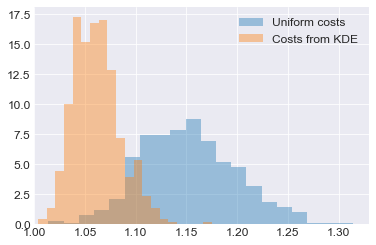

In [7]:
plt.hist(
    uniform_pofs, bins=20, alpha=0.4,
    density=True, label='Uniform costs'
)
plt.hist(
    kde_pofs, bins=20, alpha=0.4,
    density=True, label='Costs from KDE'
)

plt.legend()
x0, x1 = plt.xlim()
plt.xlim(1, x1)
plt.show()

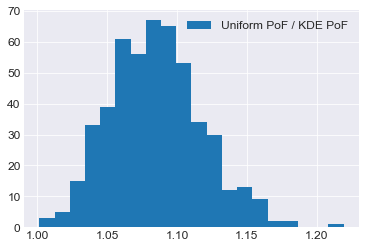

In [8]:
plt.hist(pof_ratios, bins=20, label='Uniform PoF / KDE PoF')

plt.legend()
x0, x1 = plt.xlim()
if x0 > 1:
    plt.xlim(1, x1)
plt.show()

# Similarly sorted matrices, multiple distributions

In [4]:
labels = [
    'Uniform',
    'Beta(0.1, 0.6)',
    'Beta(1, 6)',
    'Beta(2, 5)',
    'Beta(5, 2)',
    'Beta(6, 1)',
    'Beta(0.6, 0.1)',
    'Beta(0.5, 0.5)'
]

uniform_params = (0, 1)
uniform_distribution = np.random.uniform

matrix_generator = matrix_gen.MatrixGenerator(
    uniform_distribution,
    uniform_params,
    N, N_INTVS
)

other_dists = [
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta
]

other_dists_params = [
    (0.1, 0.6),
    (1, 6),
    (2, 5),
    (5, 2),
    (6, 1),
    (0.6, 0.1),
    (0.5, 0.5)
]

pof_population = [[]] + [[] for _ in other_dists]

for _ in tqdm(range(N_EXPERIMENTS)):
    matrix_list = matrix_generator.get_matrix_list(
        len(other_dists), other_dists, other_dists_params,
        sort_rows=True
    )
    
    for i, matrix in enumerate(matrix_list):
        # Efficient assignment
        eff_assigner = assignment.AssignmentHelperV2(
            matrix, CAPACITIES
        )
        eff_assignments = eff_assigner.ip_solve()
        eff_cost = eff_assigner.get_cost(eff_assignments)
        
        # Leximin assignment
        lex_assigner = leximin_assignment.LeximinAssignmentHelperV3(
            matrix, CAPACITIES
        )
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            lex_assignments = lex_assigner.solve()
        lex_cost = lex_assigner.get_cost(lex_assignments)
        
        pof_population[i].append(lex_cost / eff_cost)

100%|██████████| 500/500 [52:17<00:00,  6.27s/it]


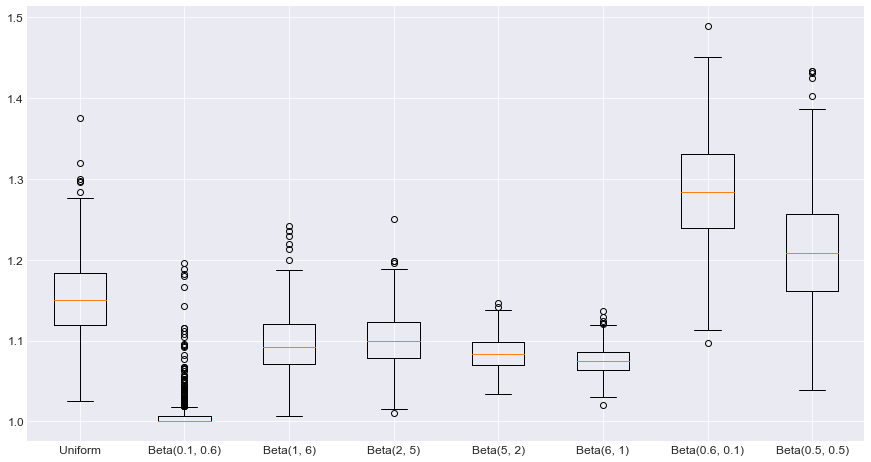

In [5]:
plt.figure(figsize=(15, 8))

plt.boxplot(
    pof_population,
    labels=labels
)

plt.show()

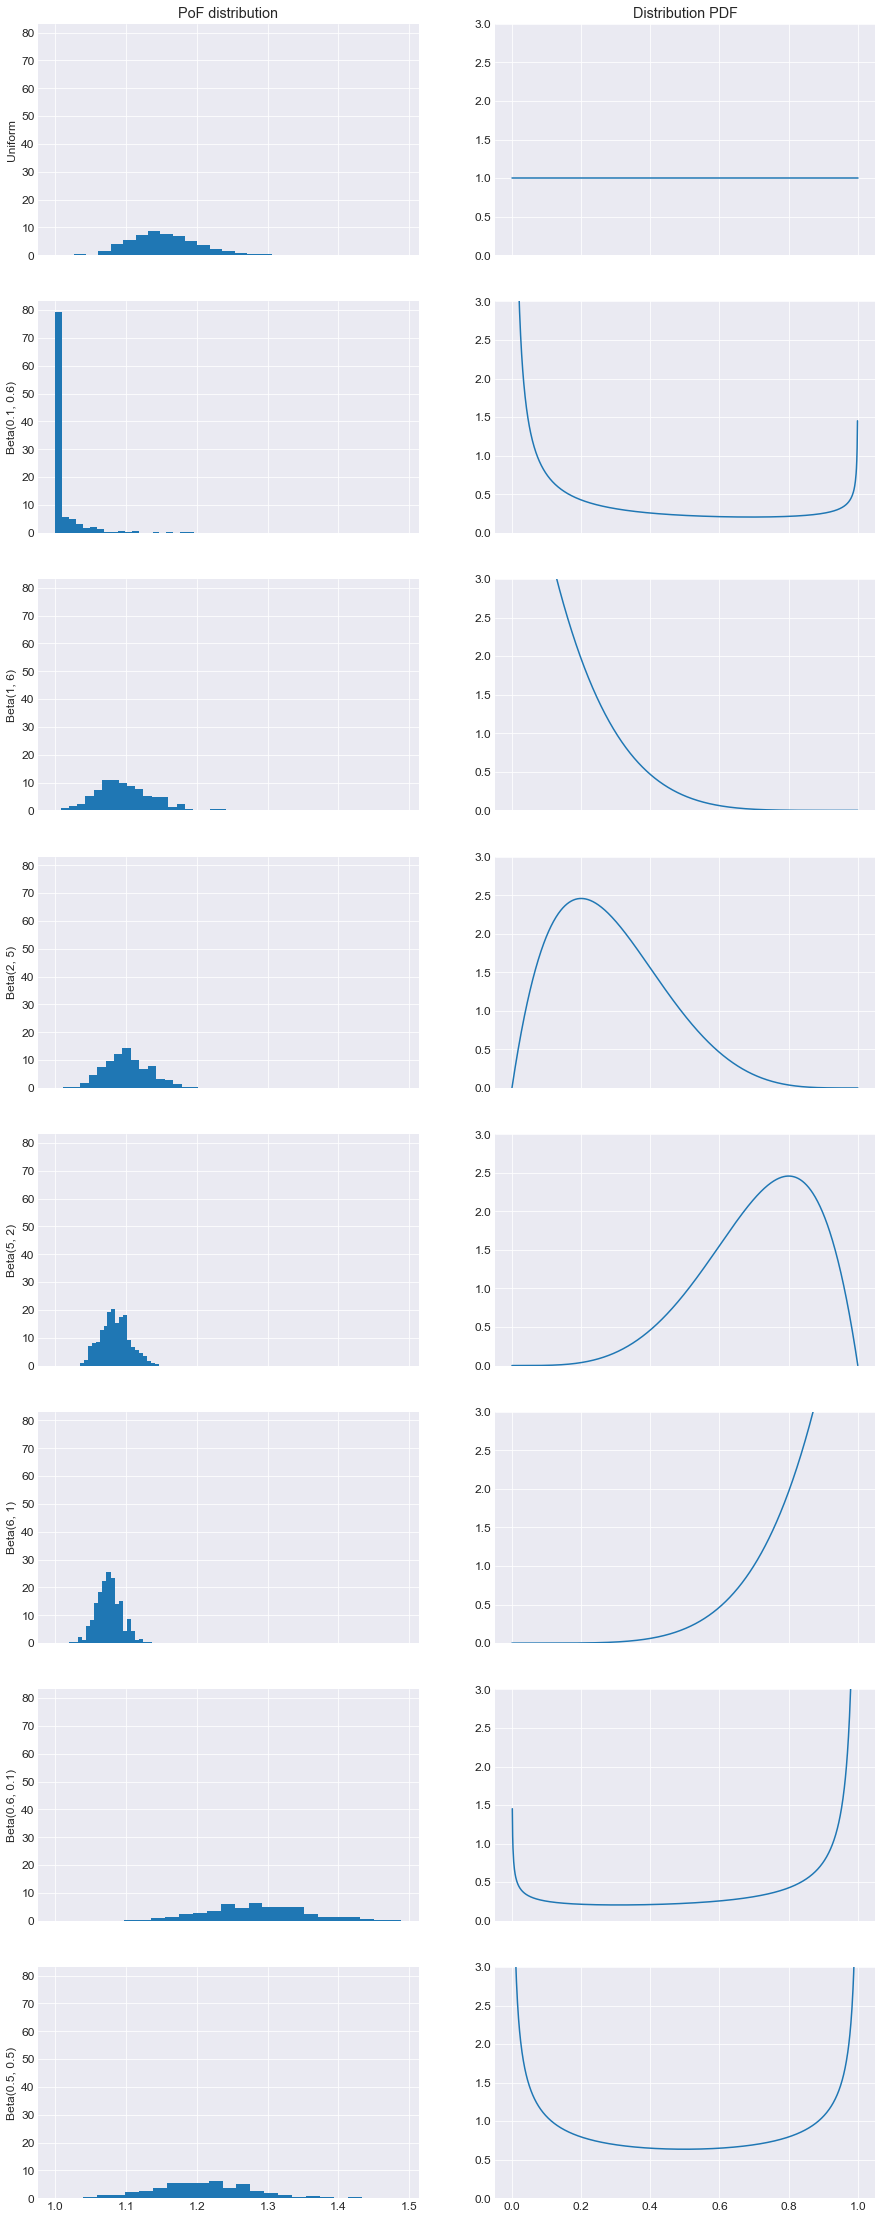

In [6]:
fig, ax = plt.subplots(
    len(labels), 2,
    figsize=(15, len(labels) * 5),
    sharex='col', sharey='col'
)

xs = np.linspace(0, 1, 1000)

for i, label in enumerate(labels):
    ax[i][0].hist(pof_population[i], bins=20, density=True)
    
    if label == 'Uniform':
        ax[i][1].plot(xs, np.ones(1000))
    else:
        ax[i][1].plot(xs, sp_beta.pdf(
            xs, a=other_dists_params[i - 1][0], b=other_dists_params[i - 1][1]
        ))
    
    ax[i][0].set_ylabel(label)
    ax[i][1].set_ylim(0, 3)
    
ax[0][0].set_title('PoF distribution')
ax[0][1].set_title('Distribution PDF')

plt.show()

# Increasing capacities

## Uniform vs. KDE

In [7]:
N = 30
N_INTVS = 5
N_EXPERIMENTS = 500  # 10 and 500

CAPACITIES = np.array([2, 4, 6, 8, 10])

In [40]:
data = df[types].to_numpy().flatten()
kde = kde_utils.KDEHelper(np.log(data) - np.log(1 - data))

uniform_params = (0, 1)
uniform_distribution = np.random.uniform

kde_params = (lambda x: 1 / (1 + np.exp(-x)), None)
kde_distribution = kde.sample_and_transform

matrix_generator = matrix_gen.MatrixGenerator(
    uniform_distribution,
    uniform_params,
    N, N_INTVS
)

uniform_pofs = []
kde_pofs = []
pof_ratios = []

for _ in tqdm(range(N_EXPERIMENTS)):
    uniform_matrix, kde_matrix = matrix_generator.get_matrix_pair(
        kde_distribution, kde_params, sort_rows=True
    )
    
    for i, matrix in enumerate([uniform_matrix, kde_matrix]):
        # Efficient assignment
        eff_assigner = assignment.AssignmentHelperV2(
            matrix, CAPACITIES
        )
        eff_assignments = eff_assigner.ip_solve()
        eff_cost = eff_assigner.get_cost(eff_assignments)
        
        # Leximin assignment
        lex_assigner = leximin_assignment.LeximinAssignmentHelperV3(
            matrix, CAPACITIES
        )
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            lex_assignments = lex_assigner.solve()
        lex_cost = lex_assigner.get_cost(lex_assignments)
        
        if i == 0:
            uniform_pofs.append(lex_cost / eff_cost)
        else:
            kde_pofs.append(lex_cost / eff_cost)
    
    pof_ratios.append(uniform_pofs[-1] / kde_pofs[-1])
    
uniform_pofs = np.array(uniform_pofs)
kde_pofs = np.array(kde_pofs)
pof_ratios = np.array(pof_ratios)

100%|██████████| 500/500 [12:22<00:00,  1.49s/it]


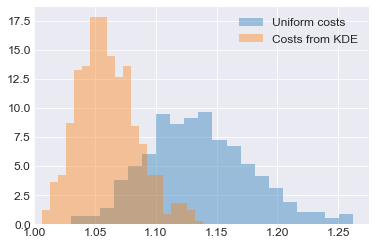

In [42]:
plt.hist(
    uniform_pofs, bins=20, alpha=0.4,
    density=True, label='Uniform costs'
)
plt.hist(
    kde_pofs, bins=20, alpha=0.4,
    density=True, label='Costs from KDE'
)

plt.legend()
x0, x1 = plt.xlim()
plt.xlim(1, x1)
plt.show()

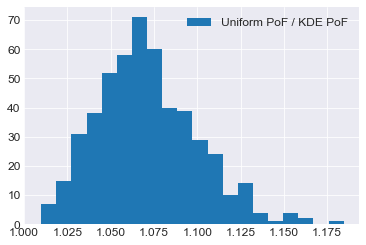

In [43]:
plt.hist(pof_ratios, bins=20, label='Uniform PoF / KDE PoF')

plt.legend()
x0, x1 = plt.xlim()
if x0 > 1:
    plt.xlim(1, x1)
plt.show()

## Multiple distributions

In [8]:
labels = [
    'Uniform',
    'Beta(0.1, 0.6)',
    'Beta(1, 6)',
    'Beta(2, 5)',
    'Beta(5, 2)',
    'Beta(6, 1)',
    'Beta(0.6, 0.1)',
    'Beta(0.5, 0.5)'
]

uniform_params = (0, 1)
uniform_distribution = np.random.uniform

matrix_generator = matrix_gen.MatrixGenerator(
    uniform_distribution,
    uniform_params,
    N, N_INTVS
)

other_dists = [
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta
]

other_dists_params = [
    (0.1, 0.6),
    (1, 6),
    (2, 5),
    (5, 2),
    (6, 1),
    (0.6, 0.1),
    (0.5, 0.5)
]

pof_population = [[]] + [[] for _ in other_dists]

for _ in tqdm(range(N_EXPERIMENTS)):
    matrix_list = matrix_generator.get_matrix_list(
        len(other_dists), other_dists, other_dists_params,
        sort_rows=True
    )
    
    for i, matrix in enumerate(matrix_list):
        # Efficient assignment
        eff_assigner = assignment.AssignmentHelperV2(
            matrix, CAPACITIES
        )
        eff_assignments = eff_assigner.ip_solve()
        eff_cost = eff_assigner.get_cost(eff_assignments)
        
        # Leximin assignment
        lex_assigner = leximin_assignment.LeximinAssignmentHelperV3(
            matrix, CAPACITIES
        )
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            lex_assignments = lex_assigner.solve()
        lex_cost = lex_assigner.get_cost(lex_assignments)
        
        pof_population[i].append(lex_cost / eff_cost)

100%|██████████| 500/500 [56:01<00:00,  6.72s/it]


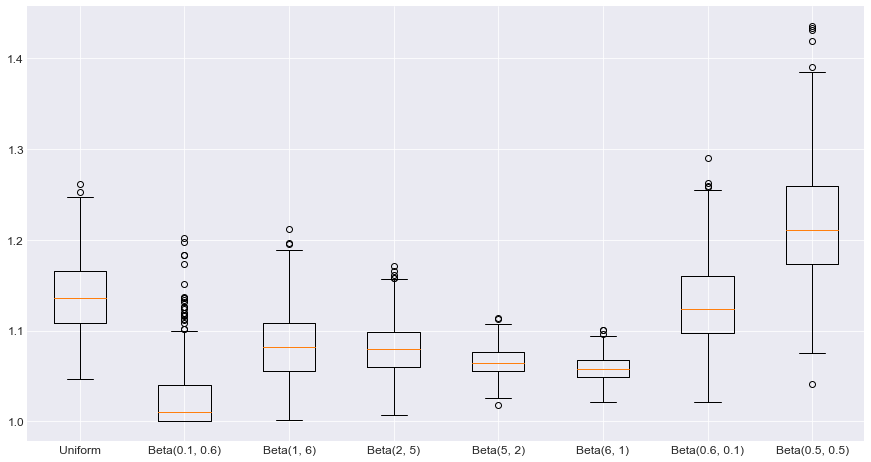

In [9]:
plt.figure(figsize=(15, 8))

plt.boxplot(
    pof_population,
    labels=labels
)

plt.show()

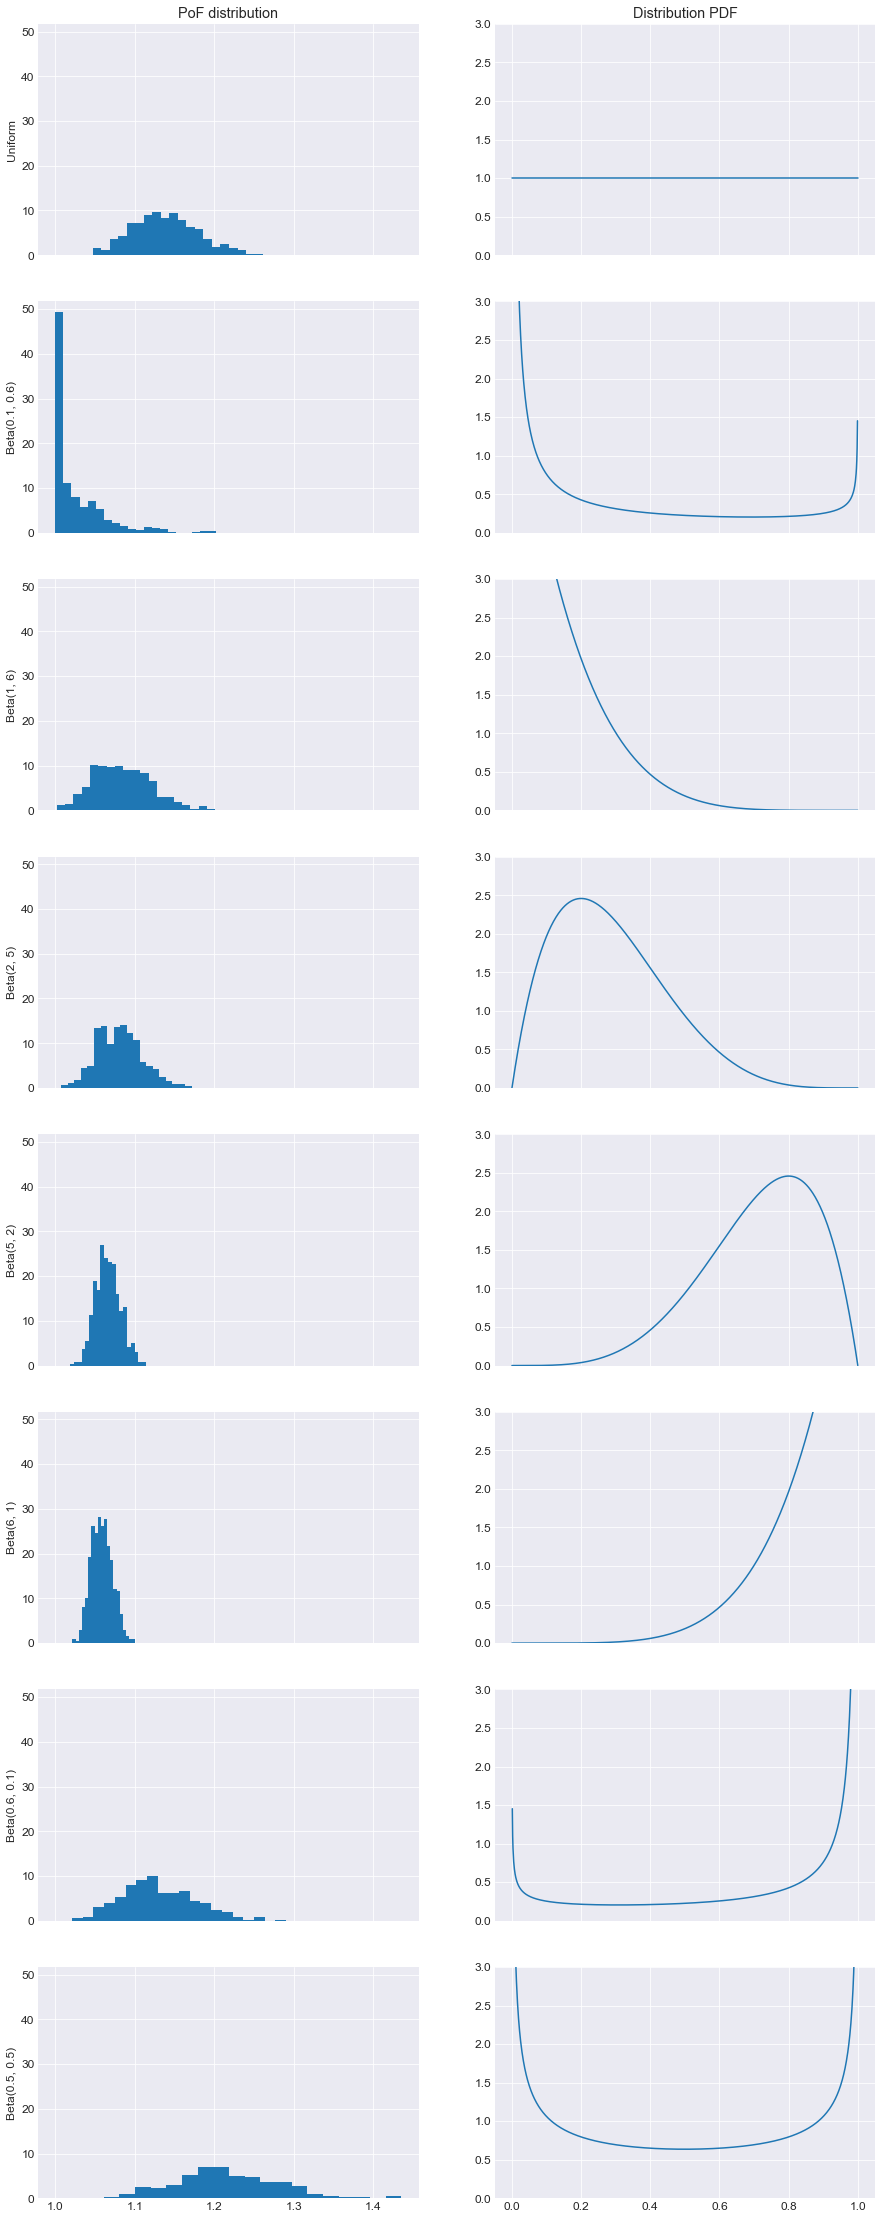

In [10]:
fig, ax = plt.subplots(
    len(labels), 2,
    figsize=(15, len(labels) * 5),
    sharex='col', sharey='col'
)

xs = np.linspace(0, 1, 1000)

for i, label in enumerate(labels):
    ax[i][0].hist(pof_population[i], bins=20, density=True)
    
    if label == 'Uniform':
        ax[i][1].plot(xs, np.ones(1000))
    else:
        ax[i][1].plot(xs, sp_beta.pdf(
            xs, a=other_dists_params[i - 1][0], b=other_dists_params[i - 1][1]
        ))
    
    ax[i][0].set_ylabel(label)
    ax[i][1].set_ylim(0, 3)
    
ax[0][0].set_title('PoF distribution')
ax[0][1].set_title('Distribution PDF')

plt.show()

# Decreasing capacities

## Uniform vs. KDE

In [11]:
N = 30
N_INTVS = 5
N_EXPERIMENTS = 500  # 10 and 500

CAPACITIES = np.array([10, 8, 6, 4, 2])

In [14]:
data = df[types].to_numpy().flatten()
kde = kde_utils.KDEHelper(np.log(data) - np.log(1 - data))

uniform_params = (0, 1)
uniform_distribution = np.random.uniform

kde_params = (lambda x: 1 / (1 + np.exp(-x)), None)
kde_distribution = kde.sample_and_transform

matrix_generator = matrix_gen.MatrixGenerator(
    uniform_distribution,
    uniform_params,
    N, N_INTVS
)

uniform_pofs = []
kde_pofs = []
pof_ratios = []

for _ in tqdm(range(N_EXPERIMENTS)):
    uniform_matrix, kde_matrix = matrix_generator.get_matrix_pair(
        kde_distribution, kde_params, sort_rows=True
    )
    
    for i, matrix in enumerate([uniform_matrix, kde_matrix]):
        # Efficient assignment
        eff_assigner = assignment.AssignmentHelperV2(
            matrix, CAPACITIES
        )
        eff_assignments = eff_assigner.ip_solve()
        eff_cost = eff_assigner.get_cost(eff_assignments)
        
        # Leximin assignment
        lex_assigner = leximin_assignment.LeximinAssignmentHelperV3(
            matrix, CAPACITIES
        )
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            lex_assignments = lex_assigner.solve()
        lex_cost = lex_assigner.get_cost(lex_assignments)
        
        if i == 0:
            uniform_pofs.append(lex_cost / eff_cost)
        else:
            kde_pofs.append(lex_cost / eff_cost)
    
    pof_ratios.append(uniform_pofs[-1] / kde_pofs[-1])
    
uniform_pofs = np.array(uniform_pofs)
kde_pofs = np.array(kde_pofs)
pof_ratios = np.array(pof_ratios)

100%|██████████| 500/500 [13:03<00:00,  1.57s/it]


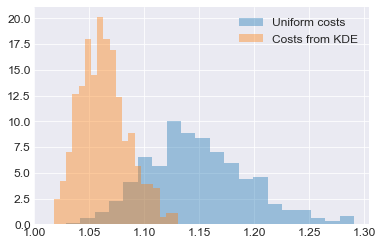

In [15]:
plt.hist(
    uniform_pofs, bins=20, alpha=0.4,
    density=True, label='Uniform costs'
)
plt.hist(
    kde_pofs, bins=20, alpha=0.4,
    density=True, label='Costs from KDE'
)

plt.legend()
x0, x1 = plt.xlim()
plt.xlim(1, x1)
plt.show()

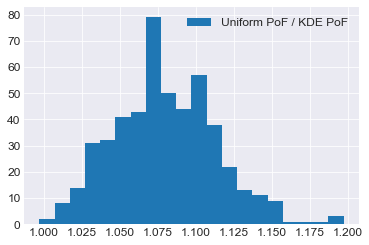

In [16]:
plt.hist(pof_ratios, bins=20, label='Uniform PoF / KDE PoF')

plt.legend()
x0, x1 = plt.xlim()
if x0 > 1:
    plt.xlim(1, x1)
plt.show()

## Multiple distributions

In [12]:
labels = [
    'Uniform',
    'Beta(0.1, 0.6)',
    'Beta(1, 6)',
    'Beta(2, 5)',
    'Beta(5, 2)',
    'Beta(6, 1)',
    'Beta(0.6, 0.1)',
    'Beta(0.5, 0.5)'
]

uniform_params = (0, 1)
uniform_distribution = np.random.uniform

matrix_generator = matrix_gen.MatrixGenerator(
    uniform_distribution,
    uniform_params,
    N, N_INTVS
)

other_dists = [
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta
]

other_dists_params = [
    (0.1, 0.6),
    (1, 6),
    (2, 5),
    (5, 2),
    (6, 1),
    (0.6, 0.1),
    (0.5, 0.5)
]

pof_population = [[]] + [[] for _ in other_dists]

for _ in tqdm(range(N_EXPERIMENTS)):
    matrix_list = matrix_generator.get_matrix_list(
        len(other_dists), other_dists, other_dists_params,
        sort_rows=True
    )
    
    for i, matrix in enumerate(matrix_list):
        # Efficient assignment
        eff_assigner = assignment.AssignmentHelperV2(
            matrix, CAPACITIES
        )
        eff_assignments = eff_assigner.ip_solve()
        eff_cost = eff_assigner.get_cost(eff_assignments)
        
        # Leximin assignment
        lex_assigner = leximin_assignment.LeximinAssignmentHelperV3(
            matrix, CAPACITIES
        )
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            lex_assignments = lex_assigner.solve()
        lex_cost = lex_assigner.get_cost(lex_assignments)
        
        pof_population[i].append(lex_cost / eff_cost)

100%|██████████| 500/500 [55:18<00:00,  6.64s/it]


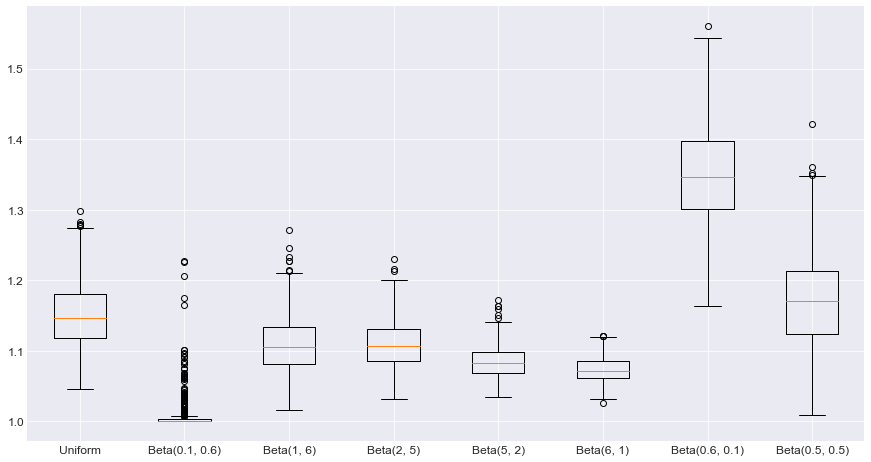

In [13]:
plt.figure(figsize=(15, 8))

plt.boxplot(
    pof_population,
    labels=labels
)

plt.show()

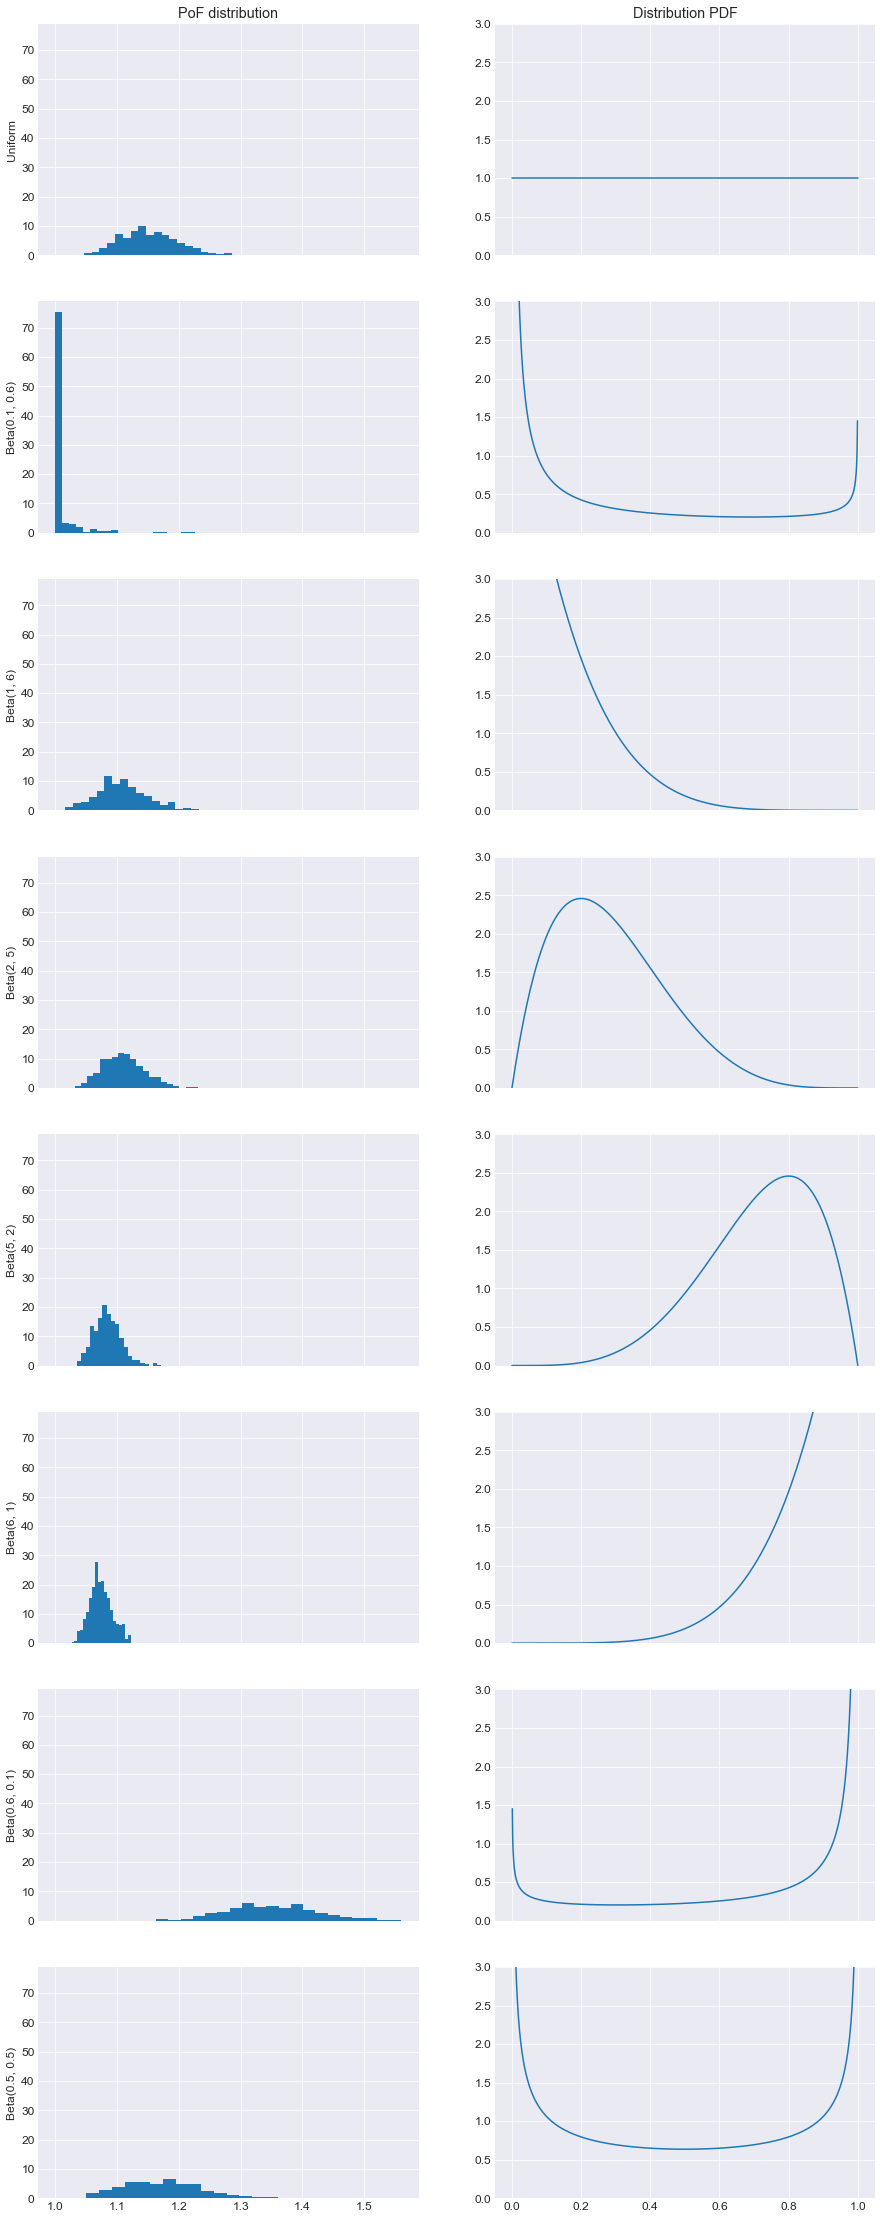

In [14]:
fig, ax = plt.subplots(
    len(labels), 2,
    figsize=(15, len(labels) * 5),
    sharex='col', sharey='col'
)

xs = np.linspace(0, 1, 1000)

for i, label in enumerate(labels):
    ax[i][0].hist(pof_population[i], bins=20, density=True)
    
    if label == 'Uniform':
        ax[i][1].plot(xs, np.ones(1000))
    else:
        ax[i][1].plot(xs, sp_beta.pdf(
            xs, a=other_dists_params[i - 1][0], b=other_dists_params[i - 1][1]
        ))
    
    ax[i][0].set_ylabel(label)
    ax[i][1].set_ylim(0, 3)
    
ax[0][0].set_title('PoF distribution')
ax[0][1].set_title('Distribution PDF')

plt.show()